# Question 1

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, stats
from statsmodels.stats.multitest import multipletests
from tqdm import tqdm

## Part a

For each gene $i = 1,...,100$ we want to test whether the gene expression of a healthy patient $\mu_{0,i}$ is equal to that of a patient with colon cancer $\mu_{1,i}$. The hypotheses we test are:

$$
H_{0,i}: \mu_{0,i} = \mu_{1,i} \\
H_{1,i}: \mu_{0,i} \neq \mu_{1,i},
$$ 

for $i = 1,...,100$.

## Part b

**Independence of Tests**

Independence of statistical hypothesis testing implies that the result of one test does not influence the result of another. In gene expression data, this assumption can be problematic. For example:

- Genes might interact with each other in complex biological pathways, meaning changes in the expression of one gene can influence the expression of others.

- Both healthy individuals and cancer patients might share genetic backgrounds that influence multiple genes simultaneously.

- Variations in how the samples are processed and measured can introduce correlations between the expression levels of different genes.

**Implications**

- When tests are not independent, the FDR control methods (like the Benjamini-Hochberg procedure) may not work as expected. These methods often assume independence for their theoretical guarantees.

- Lack of independence can affect the power of tests, leading to an increase in type I errors or type II errors.

## Part c

Load data:

In [2]:
healthy = pd.read_csv("healthy.csv", index_col=0)
cancer = pd.read_csv("cancer.csv", index_col=0)

Conducting t-tests for each gene and gather the p-values by using `ttest_ind` with `equal_var=False` because we have datasets with different sample sizes and variance:

In [3]:
p_values = []
for gene in healthy.columns:
    _, p_val = ttest_ind(healthy[gene], cancer[gene], equal_var=False)
    p_values.append(p_val)

# store results in a datframe
p_val_df = pd.DataFrame({
    "gene": healthy.columns,
    "p_value": p_values
})

Benjamini-Hochberg procedure by using `multipletests` with `method="fdr_bh"`:

In [4]:
q = 0.1  # set FDR treshold

_, corrected_p_values, _, _ = multipletests(p_val_df["p_value"], alpha=q, method="fdr_bh")
p_val_df["corrected_p_values"] = corrected_p_values

Identifying significant genes using the FDR treshold $q = 0.1$:

In [5]:
significant_genes = p_val_df[p_val_df['corrected_p_values'] < q]
significant_genes

,gene,p_value,corrected_p_values
0,R78934,0.000037,0.000928
7,T72889,0.002740,0.022833
16,T51529,0.000016,0.000924
25,T62856,0.011962,0.059812
26,D25217,0.016766,0.076211
27,M26697,0.000028,0.000924
28,T65003,0.003539,0.024971
30,D21261,0.000587,0.007339
32,R28373,0.013521,0.064388
36,R34698,0.000710,0.007888


In [6]:
len(significant_genes)

25

Using the Benjamini-Hochberg procedure with a FDR threshold of $q = 0.1$, we identified 25 genes that show statistically significant differences in expression between healthy individuals and patients with colon cancer. This implies that these genes may be associated with or potentially play a role in the development or progression of colon cancer. By setting the FDR threshold to 0.1, we accept that up to 10% of the genes identified as significant may be false positives. The genes identified as significant could be potential biomarkers for colon cancer or targets for further biological research.

## Part d

In [7]:
K = len(p_val_df["p_value"])  # number of tests corresponding to 100 genes
ordered_p_values = p_val_df["p_value"].sort_values()
ordered_hypotheses = ordered_p_values.index

In [8]:
# critical value for each hypothesis
critical_values = [q * (i+1) / K / sum(1/(j+1) for j in range(K)) for i in range(K)]
i_star = max([i for i, p_val in enumerate(ordered_p_values) if p_val <= critical_values[i]])
i_star

9

In [9]:
# Rejecting all H0,(i) for i = 1,...,i* and getting the gene names
significant_genes_alternative = p_val_df.iloc[ordered_hypotheses[:i_star+1]]['gene']
significant_genes_alternative

16    T51529
76    T51023
27    M26697
0     R78934
52    H70425
88    L28010
79    D63874
30    D21261
36    R34698
77    T63133
Name: gene, dtype: object

In [10]:
len(significant_genes_alternative)

10

In Part c with Benjamini-Hochberg we identified 25 genes to be significantly differentially expressed between healthy individuals and patients with colon cancer. With the alternative procedure we identified 10 genes as significant. This suggests that the Benjamini-Hochberg procedure is more liberal in rejecting null hypotheses, leading to a higher number of potential discoveries. The alternative procedure appears to be more conservative, identifying fewer genes as significant. This could imply that it has a stricter control over the FDR, leading to fewer false positives but potentially more false negatives.

The genes identified by the Benjamini-Hochberg procedure but not by the alternative procedure may warrant further investigation. The genes identified by both methods can be considered as having stronger evidence for differential expression.

## Part e

### Part i

False Discovery Rate is a metric used in multiple hypothesis tests. It measures the expected proportion of false positives among all rejections. This is particularly relevant in high-throughput experiments like genomic studies, where testing a large number of hypotheses simultaneously is common. FDR is a more practical and relevant measure in such contexts compared to the family-wise error rate (FWER), as it offers a balance between discovering significant results and controlling for false positives, especially when the number of tests is large.

When working with real data the true status of each hypothesis is unknown, making it challenging to calculate the FDR precisely. To know the FDR, we need to know how many of the tests are true null hypotheses, which is typically unknown in real-world scenarios. Additionally, real data often have complex dependencies and may not follow strictly theoretical assumptions of distribution, which complicates the estimation of FDR.

### Part ii

The simulation of the data aligns with typical scenarios in gene expression studies, reflecting realistic biological and statistical properties. Hence, normal distribution is being used. In many biological systems, gene expression levels tend to follow a normal distribution. This is particularly true when large numbers of molecular contribute to the observed expression levels, as per the central limit theorem. The normal distribution is also  symmetric and defined by its mean and variance, making it a flexible model for simulating both null and alternative hypotheses. 

For true null hypotheses (no real difference between the groups), data for both groups are drawn from the same normal distribution (a standard normal distribution). For false null hypotheses (a real difference exists), data for the two groups are drawn from normal distributions with different means. This difference in means represents the effect size or the magnitude of the difference in gene expression between the groups. 
   
The choice of effect size is important. It should reflect differences that might be biologically significant and detectable in actual gene expression data. We are going to use an effect size of 1 (a "standardized" effect size) where the difference between the means of the two groups is equal to one standard deviation of the distribution. This provides a clear and interpretable magnitude of difference. It creates a balanced scenario which is neither too easy nor too difficult for statistical methods to detect. 

Using a standard normal distribution as a baseline for both the null and one part of the alternative hypothesis simplifies the simulation. It provides a clear contrast between the 'no effect' and 'effect present' scenarios, making it easier to interpret the results of the hypothesis testing methods.

In [11]:
def simulate_data(m, K, effect_size, sample_size_healthy, sample_size_cancer):
    """Simulate two datasets with K genes, where m of the K null hypotheses are true.
    """
    # null hypotheses: no effect
    healthy_null = np.random.normal(0, 1, size=(m, sample_size_healthy))
    cancer_null = np.random.normal(0, 1, size=(m, sample_size_cancer))

    # alternative hypotheses: effect present
    healthy_alt = np.random.normal(0, 1, size=(K - m, sample_size_healthy))
    cancer_alt = np.random.normal(effect_size, 1, size=(K - m, sample_size_cancer))

    return np.vstack((healthy_null, healthy_alt)), np.vstack((cancer_null, cancer_alt))

In [12]:
def calculate_p_values(data_group1, data_group2):
    """Perform t-tests and return p-values.
    """
    p_values = []
    for i in range(data_group1.shape[0]):
        _, p_val = ttest_ind(data_group1[i], data_group2[i], equal_var=False)
        p_values.append(p_val)
    
    return np.array(p_values)

In [13]:
def estimate_FDR(m, K, n, effect_size, fdr_threshold, sample_size_group1, sample_size_group2):
    """Estimate FDR for Benjamini-Hochberg and alternative procedure.
    """
    fdr_bh = []
    fdr_alternative = []
    for _ in range(n):
        # Simulate data
        data_group1, data_group2 = simulate_data(m, K, effect_size, sample_size_group1, sample_size_group2)

        # Calculate p-values
        p_values = calculate_p_values(data_group1, data_group2)

        # Benjamini-Hochberg Procedure
        _, p_adj_bh, _, _ = multipletests(p_values, alpha=fdr_threshold, method='fdr_bh')
        rejections_bh = p_adj_bh < fdr_threshold
        fdr = np.sum(rejections_bh & (np.arange(K) < m)) / max(np.sum(rejections_bh), 1)
        fdr_bh.append(fdr)

        # Alternative Procedure
        p_sorted_indices = np.argsort(p_values)
        p_sorted = p_values[p_sorted_indices]
        critical_values = [fdr_threshold * (i+1) / K / sum(1/(j+1) for j in range(K)) for i in range(K)]
        i_star = np.max(np.where(p_sorted <= critical_values)) if np.any(p_sorted <= critical_values) else -1

        rejections_alternative = np.zeros(K, dtype=bool)
        rejections_alternative[p_sorted_indices[:i_star+1]] = True
        fdr_alt = np.sum(rejections_alternative & (np.arange(K) < m)) / max(np.sum(rejections_alternative), 1)
        fdr_alternative.append(fdr_alt)
    
    return np.mean(fdr_bh), np.mean(fdr_alternative)

The choice of $n$ (number of simulations for estimating the FDR), involves a trade-off between computational cost and the precision of the FDR estimate. Larger values of \( n \) will lead to more stable and reliable estimates of the FDR. This is because averaging the results over a greater number of simulations reduces the variability. Choosing $n = 1000$ should be sufficient, providing a good balance between computational cost and statistical stability.

In [14]:
K = 100  # number of hypotheses, corresponding to 100 genes
effect_size = 1.0  # effect size for alternative hypotheses
n = 1000  # number of simulations
q = 0.1  # FDR threshold
sample_size_healthy = 30
sample_size_cancer = 40

fdr_results = {'m': [], 'FDR_BH': [], 'FDR_Alternative': []}
for m in tqdm(range(0, K+1, 5)):
    fdr_bh, fdr_alternative = estimate_FDR(m, K, n, effect_size, q, sample_size_healthy, sample_size_cancer)
    fdr_results['m'].append(m)
    fdr_results['FDR_BH'].append(fdr_bh)
    fdr_results['FDR_Alternative'].append(fdr_alternative)

100%|██████████| 21/21 [07:50<00:00, 22.41s/it]


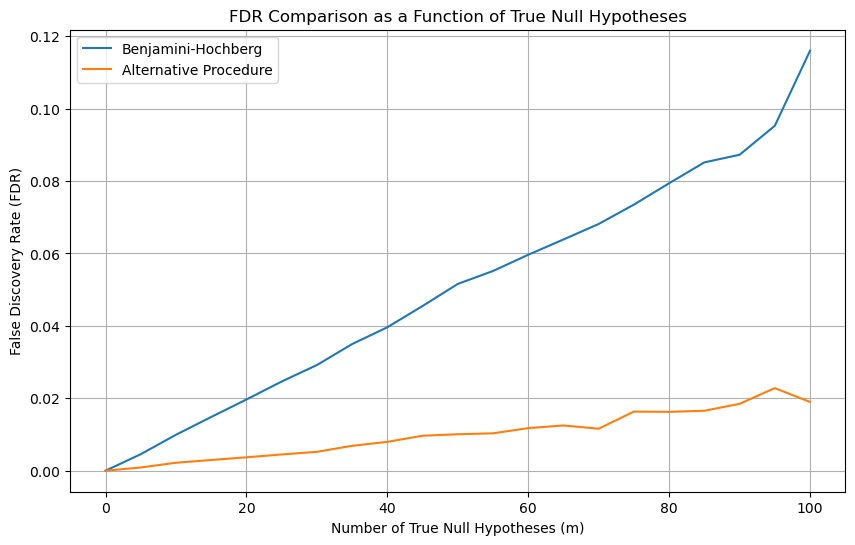

In [15]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(fdr_results['m'], fdr_results['FDR_BH'], label='Benjamini-Hochberg')
plt.plot(fdr_results['m'], fdr_results['FDR_Alternative'], label='Alternative Procedure')
plt.xlabel('Number of True Null Hypotheses (m)')
plt.ylabel('False Discovery Rate (FDR)')
plt.title('FDR Comparison as a Function of True Null Hypotheses')
plt.legend()
plt.grid(True)
plt.show()

We have simulated two datasets: one imitating the healthy dataset with 30 samples, and one imitating the cancer dataset with 40 samples. The number of hypotheses is 100 imitating the 100 genes from the given datasets. Again the FDR treshold is set to 0.1. The estimation is done after 1000 iterations.

In the plot, the FDR for both procedures is relatively low (not exceeding the 0.1 treshold) and stable as the number of true null hypotheses increases. The plot shows that the Benjamini-Hochberg procedure maintains a low FDR across different numbers of true null hypotheses, which is expected and indicates that the procedure is performing as intended. But it is noticable that it is inceraing with the increase in the number of true null hypotheses. In the case of 100% true null hypotheses the estimated FDR is usually very close to the threshold of 0.1, sometimes exceeding it slighlty, sometimes staying below it.

The Alternative procedure has steady lower estimated FDR values when increasing the number of true null hypotheses. Even for the case with 100% true null hypotheses the estimated FDR is close to 0 and not very different from the previous values. This suggests the alternative procedure is very conservative in rejecting null hypotheses, and that the Benjamini-Hochberg procedure may not control the FDR as effectively as the alternative procedure.

## Part f

In [16]:
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import numpy as np

# Conducting t-tests for each gene
p_values = []
for gene in healthy.columns:
    t_stat, p_val = ttest_ind(healthy[gene], cancer[gene], equal_var=False)
    p_values.append(p_val)
p_values = np.array(p_values)

import numpy as np

# Benjamini-Hochberg procedure
q = 0.1
_, corrected_p_values_BH, _, _ = multipletests(p_values, alpha=q, method='fdr_bh')
BH_rejections = corrected_p_values_BH < q

# alternative procedure
p_sorted_indices = np.argsort(p_values)
p_sorted = p_values[p_sorted_indices]
K = len(p_values)
critical_values = [q * (i+1) / K / sum(1/(j+1) for j in range(K)) for i in range(K)]
i_star = max(np.where(p_sorted <= critical_values)[0], default=-1)
alternative_rejections = np.zeros(K, dtype=bool)
alternative_rejections[p_sorted_indices[:i_star+1]] = True

# Find p-values where decisions differ: having been classified as true/false and false/true respectively
divergent_p_values = p_values[(BH_rejections != alternative_rejections)]
divergent_p_values

array([0.00273991, 0.01196231, 0.01676646, 0.00353865, 0.01352144,
       0.02192995, 0.01036798, 0.0025316 , 0.00966321, 0.02137241,
       0.00813533, 0.00478098, 0.0034857 , 0.00374571, 0.02396047])

In [17]:
len(divergent_p_values)

15

If a set of p-values where the decisions of the Benjamini-Hochberg procedure and the alternative procedure differ significantly, it can imply the dataset may contain a mix of very strong signals (extremely low p-values) and weaker signals (moderately low p-values). The very low p-values are likely to be rejected by both procedures, but the moderately low p-values might be treated differently, indicating a range of effect sizes among the tested hypotheses. Also, the distribution of p-values might not be uniform. The divergence in decisions between the two procedures might highlight their sensitivity to the distribution of p-values.

After checking with the results from Part c and Part d, it turns out all of the 15 identified genes come from the Benjamini-Hochberg  procedure. It introduces 15 more potential significant genes not considered by the alternative procedure.

## Part g

In the context of gene expression data related to cancer, it is important to identify for further research as much as possible genes which are potentially contributing to the development of the disease. It is better to put effort into researching more genes rather than to miss a gene which might actually be contributing to cancer progression.  
The Benjamini-Hochberg procedure is less conservative potentially leading to more discoveries (but with a higher chance of false positives which is not a problem for the purpose of the results as already outined), and we identified 25 genes. The alternative procedure is more conservative (as it might be affected more by very small p-values), and it might lead to fewer discoveries but with higher confidence in the results being true positives. With it we identified only 10 genes. It is worth noting that the 10 genes identified in the alternative procedure are all present among the 25 genes identified with the Benjamini-Hochberg procedure.

Based on these results I would suggest using Benjamini-Hochberg just to stay on the safe side and not miss some potenital contributing genes among the 15 additional genes identified by Benjamini-Hochberg compared to the alternative procedure.

# Question 2

## Part a

**Test I**: There's a 0.5 probability of assigning a user to each group, therefore, the data should accumulate at the same rate for both groups. This balanced scenario results in a steadier increase in power as more data is collected, or we would expect this line to increase more smoothly and steadily.

**Test II**: With a 0.9 probability of assigning a user to group A, and a 0.1 to group B, the group B data will accumulate much slower. High power requires sufficient data from both groups to detect a difference, hence the line for Test II is expected to increase more slowly. However, when enough data from group B is available, the power can increase rapidly because there's already an abundance of data from group A.

In conclusion, the line that increases more steadily and reaches the power of 0.8 with fewer samples is likely to correspond to Test I (equal allocation) - this is the orange line, and the line that increases more slowly initially but then rises sharply to reach the power of 0.8 is likely to correspond to Test II - the blue line.

## Part b

**Expectation**:

An increase of the effect size results in an increase of the power. This means that for a fixed number of samples, the power to detect the effect would be greater if the effect size were larger. Or, both curves would reach the desired level of 0.8 at a lower sample size than before.

With an increased effect size, the slope of the power curves would become steeper because each additional sample contributes more to the ability to detect the true effect. Larger effect sizes make differences between groups easier to detect, with the power increasing more rapidly as the sample size increases. 

Moreover, a larger effect size might "correct" the disadvantage of the unequal allocation in Test 2 because even the smaller sample from group B would provide enough evidence of the effect. This means the gap between the curves when achieving the desired power level might decrease.

**Considerations:**

To determine which effect size should be used we can consider knowledge from previous experiments in the field, which can give us an estimate of the typical values in the context. Depending on the use case, for example in a business setting, we might have to work on determining the smallest effect size that would be practically significant (the smallest change in user/customer behavior that is still important for the business goals). Another approach might be to conduct a small scale study to gain perspective on the effect size values which can then be used to plan a larger experiment. From a statistical perspective, a power analysis can be performed to determine the sample size needed to detect the effect size at a given level of power (let's say at least 0.8, which is most commonly used) and significance level (commonly 0.05).

## Part c

Let's note that Test I had a 0.5 probability for each group and Test II had a 0.9 probability for group A and 0.1 for group B. Thus, we can consider weighting the results of the tests according to these probabilities or the actual sample sizes when combining the p-values. The differences in allocation probabilities can introduce bias into the result: if group B’s sample size is smaller, its estimate of the mean will be less precise, and might affect the p-value. Also, tests should be independent, otherwise the combination methods may not be appropriate. Moreover, when combining results from multiple tests, there's an increased risk of Type I error. An adjustment might be needed to maintain the overall Type I error rate, for example FDR.

If we have compatible tests and assumptions, we can perform a combined analysis with data pooled from both tests, and recalulcate the p-values. We can use statistical methods from meta-analysis to combine the p-values, where effect sizes and their variances are used to obtain a weighted average effect size, which is then tested for significance. Fisher's method combines the p-values from different tests by taking their logarithms, multiplying by -2, and then summing these values. The resulting statistic has a chi-square distribution with degrees of freedom equal to twice the number of tests. It is important to note this method assumes the tests are independent.

In summary, if we want to combine the outcomes of Test I and Test II, the method chosen should be appropriate given the independence and the tests design. If tey are independent and the designs are considered equally valid, Fisher's or Stouffer's could be appropriate.

## Part d

We aim to define an adaptive procedure for gradually increasing the proportion of users in group B while monitoring performance. We can outline the approach below:

- we can begin with a small proportion of users seeing version B as requested by the stakeholder

- we should define performance benchmarks based on some metric: for example version B must reach or even exceed a pre-set user engagement, time spent on the website, click thourh rate, etc.

- continuous monitoring of the metrics against the set benchmarks is crucial

- when version B meets or exceeds the benchmarks, incrementally increase (gradually - rapid changes in exposure could have operational implications, such as server load) the proportion of users who see it

- it is a good idea to define a maximum proportion for version B that should not be exceeded until the final decision is made to fully implement the new version

- in case the performance drops below the benchmarks, a decision should be made to either reduce the exposure of version B or revert to version A

The procedure will focus more on the practical side of the problem, working with business defined metrics directly reflecting the user behaviour, rather then the statistical tests results. Decisions in business are usually based on performance indicators rather than purely statistical significance. Business metrics are easy to understand from everyone and  provide clear guidelines for when to increase or decrease exposure to version B and includes a cap on exposure for risk management.

We can also perform statistical tests, where the allocation is adjusted based on the statistical evidence collected during the test, and might be preferred if the focus is on maintaining the integrity of the statistical analysis.

Here is a pseudocode outline of the adaptive procedure. 

```
initialize proportion_B to a small value = 0.1
initialize increment to a small value = 0.05
initialize max_proportion_B to a cap value = 0.5

while not end of test period:
    measure performance metrics of version B
    (or measure statistical tests performance of version B and perform similar checks for 
    the collected statistical evidence)
    
    if performance of B >= benchmark:
        if proportion_B < max_proportion_B:
            proportion_B += increment
            proportion_A = 1 - proportion_B
        else:
            log "Version B has reached the maximum exposure limit before final decision"
    else:
        if proportion_B > initial proportion_B:
            proportion_B -= increment
            proportion_A = 1 - proportion_B
        else:
            log "Version B is not meeting performance benchmarks, consider rollback"
    
    wait for next measurement interval
```

Potential Issues:

- if the initial group of users is not representative of all users, bias might be introudced when incrementally increasing exposure based on performance 

- performance metrics trends should be stable before making changes, volatilities in their performance may lead to premature decisions for exposure changes

- frequent changes in the proportions may lead to inconsistent user experience and hence lower the satisfaction